In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

import sys
import copy
sys.path.append("../../")

import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [2]:
models = torch.load("model/gradvsODEvsFD.pt")
lagODE_model = torch.load("model/gradvsODEvsFD_lagODE.pt")
symODE_model = torch.load("model/symODE2.pt")
models.insert(1, lagODE_model)

for model in models:
    model.eval()
None

In [3]:
len(models)

12

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for model in models:
    print("{} have {} parameters".format(type(model), count_parameters(model)))

<class 'torchdyn.core.neuralde.NeuralODE'> have 75523 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75523 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 76174 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75910 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75523 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75523 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 76174 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75910 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75523 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75523 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 76174 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75910 parameters


In [5]:
test_set = torch.load('data/Cartpole_test_set.pt')
training_set = torch.load('data/Cartpole_training_set_20k.pt')

In [6]:
print(test_set.tensors[0].shape)
print(training_set.tensors[0].shape)

torch.Size([100, 100, 5])
torch.Size([20000, 7, 5])


class 'torchdyn.core.neuralde.NeuralODE'> have 75523 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 76174 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75910 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75523 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75523 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 76174 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75910 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75523 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75523 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 76174 parameters
<class 'torchdyn.core.neuralde.NeuralODE'> have 75910 parameters

Epoch 1044
--- 1056.2394649982452 seconds ---

Epoch 176
--- 648.121551990509 seconds ---

Epoch 106
--- 402.4200119972229 seconds ---

Epoch 1236
--- 794.56542801857 seconds ---

Epoch 1627
--- 455.3885178565979 seconds ---

Epoch 1406
--- 1195.7574248313904 seconds ---

Epoch 128
--- 71.83591794967651 seconds ---

Epoch 580
--- 76.03032612800598 seconds ---

Epoch 1629
--- 415.8247811794281 seconds ---

Epoch 1546
--- 1010.131778717041 seconds ---

Epoch 151
--- 64.13547492027283 seconds ---

Epoch 630
--- 62.907979011535645 seconds ---

### Get test err

In [10]:
from utils import traj_pred

In [11]:
test_traj = torch.cat([test_set.tensors[0], test_set.tensors[1]], dim=2)
train_traj = torch.cat([training_set.tensors[0], training_set.tensors[1]], dim=2)[:1000, :, :]

In [12]:
print(test_traj.shape)
print(test_set.tensors[0].shape)
print(train_traj.shape)

torch.Size([100, 100, 6])
torch.Size([100, 100, 5])
torch.Size([1000, 7, 6])


In [10]:
test_err = []
train_err = []

t_span1 = test_set.tensors[2][0, :, -1]
t_span2 = training_set.tensors[2][0, :, -1]

for i, model in enumerate(models):
    # Generate estimated trajectory
    print("cur model {}".format(i))
#     if i == 1 or i == 5 or i == 9:
#         continue
    est_trajs1 = []
    for traj_idx in range(test_traj.shape[0]):
        if traj_idx % 10 == 0:
            print("test traj {}".format(traj_idx))
        est_traj1 = traj_pred(0.02, models[i], test_traj[traj_idx, 0, :5], test_traj[traj_idx, :, [3]])
        est_trajs1.append(est_traj1.y.T)
        
    est_trajs1 = torch.tensor(est_trajs1)
        
    est_trajs2 = []
    for traj_idx in range(train_traj.shape[0]):
        if traj_idx % 1000 == 0:
            print("train {}".format(traj_idx))
        est_traj2 = traj_pred(0.02, models[i], train_traj[traj_idx, 0, :5], train_traj[traj_idx, :, [3]])
        est_trajs2.append(est_traj2.y.T)
        
    est_trajs2 = torch.tensor(est_trajs2)

    loss_test = torch.nn.functional.mse_loss(est_trajs1, test_set.tensors[0]).detach()
    loss_train = torch.nn.functional.mse_loss(est_trajs2, training_set.tensors[0][:1000, : ,:]).detach()
    
    test_err.append(loss_test)
    train_err.append(loss_train)

cur model 0
test traj 0
test traj 10
test traj 20
test traj 30
test traj 40
test traj 50
test traj 60
test traj 70
test traj 80
test traj 90
train 0
cur model 1
test traj 0
test traj 10
test traj 20
test traj 30
test traj 40
test traj 50
test traj 60
test traj 70
test traj 80
test traj 90
train 0
cur model 2
test traj 0
test traj 10
test traj 20
test traj 30
test traj 40
test traj 50
test traj 60
test traj 70
test traj 80
test traj 90
train 0
cur model 3
test traj 0
test traj 10
test traj 20
test traj 30
test traj 40
test traj 50
test traj 60
test traj 70
test traj 80
test traj 90
train 0
cur model 4
test traj 0
test traj 10
test traj 20
test traj 30
test traj 40
test traj 50
test traj 60
test traj 70
test traj 80
test traj 90
train 0
cur model 5
test traj 0
test traj 10
test traj 20
test traj 30
test traj 40
test traj 50
test traj 60
test traj 70
test traj 80
test traj 90
train 0
cur model 6
test traj 0
test traj 10
test traj 20
test traj 30
test traj 40
test traj 50
test traj 60
test

In [11]:
model_name = ['hamODE', 'lagODE', 'symODE', 'baselineODE',
              'hamODE_grad', 'lagODE_grad', 'symODE_grad', 'baselineODE_grad',
              'hamODE_fd', 'lagODE_fd', 'symODE_fd', 'baselineODE_fd']

for i in range(len(test_err)):
    print(i, model_name[i], test_err[i], train_err[i])

0 hamODE tensor(0.8454, dtype=torch.float64) tensor(0.0604, dtype=torch.float64)
1 lagODE tensor(0.6756, dtype=torch.float64) tensor(0.0605, dtype=torch.float64)
2 symODE tensor(0.6349, dtype=torch.float64) tensor(0.0604, dtype=torch.float64)
3 baselineODE tensor(0.6556, dtype=torch.float64) tensor(0.0604, dtype=torch.float64)
4 hamODE_grad tensor(0.7898, dtype=torch.float64) tensor(0.0604, dtype=torch.float64)
5 lagODE_grad tensor(0.8171, dtype=torch.float64) tensor(0.0604, dtype=torch.float64)
6 symODE_grad tensor(0.6331, dtype=torch.float64) tensor(0.0604, dtype=torch.float64)
7 baselineODE_grad tensor(0.8005, dtype=torch.float64) tensor(0.0604, dtype=torch.float64)
8 hamODE_fd tensor(0.6761, dtype=torch.float64) tensor(0.0604, dtype=torch.float64)
9 lagODE_fd tensor(0.7756, dtype=torch.float64) tensor(0.0604, dtype=torch.float64)
10 symODE_fd tensor(0.6341, dtype=torch.float64) tensor(0.0604, dtype=torch.float64)
11 baselineODE_fd tensor(0.7377, dtype=torch.float64) tensor(0.0605, 

Epoch 402
--- 3806.299942970276 seconds ---

Epoch 162
--- 5747.10022187233 seconds ---

Epoch 408
--- 16419.703307151794 seconds ---

Epoch 349
--- 1900.0472829341888 seconds ---

Epoch 552
--- 1242.2793142795563 seconds ---

Epoch 408
--- 2404.747815132141 seconds ---

Epoch 143
--- 1026.3510270118713 seconds ---

Epoch 490
--- 652.9853308200836 seconds ---

Epoch 889
--- 1923.411561012268 seconds ---

Epoch 691
--- 4678.984284877777 seconds ---

Epoch 624
--- 5364.81204199791 seconds ---

Epoch 457
--- 721.9379580020905 seconds ---

### Trajectory Test

In [13]:
from gym_env import CartPoleCustomEnv

In [50]:
# Generate Trajectory
def generate_traj(x0=np.array([0, 0, 1, 0]), t0=0, steps=200):
    env = CartPoleCustomEnv()
    env.seed(0)
    np.random.seed(0)
    obs = []
    infos = []

    split = 20
    controls = np.random.uniform(-10, 10, int(steps / split))
#     controls = np.random.choice([0, 5, -5], int(steps / split))
    controls = np.repeat(controls, split)
    controls = torch.tensor(controls)
#     controls = torch.zeros_like(controls)
    obs0, _ = env.reset(x0)

    prev_obs = obs0
    for i in range(steps):
        obs.append(prev_obs)

        next_obs, reward, done, info = env.step(controls[i])
        infos.append(np.array([info['th'], info['ddx'], info['ddth']]))
        prev_obs = next_obs
    
    obs = torch.tensor(obs)
    infos = torch.tensor(infos)

    return obs.float(), infos.float(), controls.view(-1, 1).float()

In [51]:
# Generate Trajectory from true model
t0 = 0
dt = 0.02
steps = 160
t1 = steps * dt

traj1_true, infos1, controls1 = generate_traj(x0=np.array([0, 0, 1, 0]), t0=t0, steps=steps)
traj2_true, infos2, controls2 = generate_traj(x0=np.array([0, 0, 3, 0]), t0=t0, steps=steps)

In [68]:
# Generate Estimated Trajectory
t_span = torch.linspace(t0, t1, steps)
trajs1 = []
trajs2 = []
grads1 = []
grads2 = []

for idx, model in enumerate(models):
    print("finished model {}".format(idx))
    if idx == 5:
        break
    traj1 = traj_pred(0.02, model, traj1_true[0, :5], controls1).y.T
    traj2 = traj_pred(0.02, model, traj2_true[0, :5], controls2).y.T
    
    q_dq_u1 = torch.cat([traj1_true, controls1], dim=1)
    q_dq_u2 = torch.cat([traj2_true, controls2], dim=1)
    
    est_grad1 = model.defunc(0, q_dq_u1.float()).detach()
    est_grad2 = model.defunc(0, q_dq_u2.float()).detach()
    
    
    trajs1.append(traj1)
    trajs2.append(traj2)
    grads1.append(est_grad1)
    grads2.append(est_grad2)

finished model 0
finished model 1
finished model 2
finished model 3
finished model 4
finished model 5


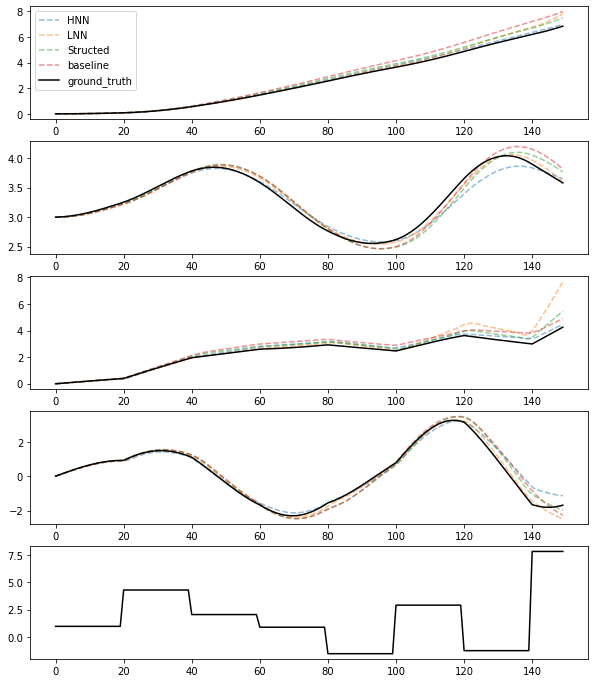

In [69]:
fig = plt.figure(figsize=(10, 12))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)

length = 150
model_idx = 2

for model_idx in range(4):
    ax1.plot(trajs2[model_idx][:length, 0], '--', alpha=0.5)

    ax2.plot(np.unwrap(np.arctan2(trajs2[model_idx][:length, 2], trajs2[model_idx][:length, 1])), '--', alpha=0.5)

    ax3.plot(trajs2[model_idx][:length, 3], '--', alpha=0.5)

    ax4.plot(trajs2[model_idx][:length, 4], '--', alpha=0.5)

    
ax1.plot(traj2_true[:length, 0], '-', color='black')
ax2.plot(infos2[:length, 0], '-', color='black')
ax3.plot(traj2_true[:length, 3], '-', color='black')
ax4.plot(traj2_true[:length, 4], '-', color='black')
ax5.plot(controls2[:length], '-', color='black')

ax1.legend(['HNN', "LNN", "Structed", 'baseline', 'ground_truth'])

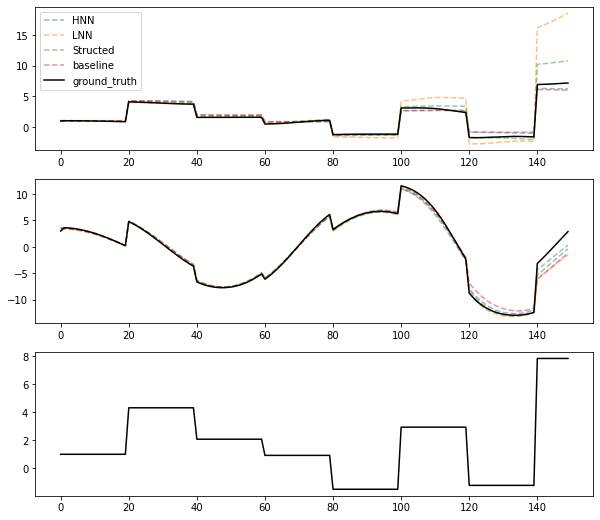

In [73]:
fig = plt.figure(figsize=(10, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

length = 150
model_idx = 2

for model_idx in range(4):
    ax1.plot(grads2[model_idx][:length, 3], '--', alpha=0.5)

    ax2.plot(grads2[model_idx][:length, 4], '--', alpha=0.5)

    
ax1.plot(infos2[:length, 1], '-', color='black')
ax2.plot(infos2[:length, 2], '-', color='black')
ax3.plot(controls2[:length], '-', color='black')

ax1.legend(['HNN', "LNN", "Structed", 'baseline', 'ground_truth'])

In [20]:
def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi

def recover_angle(angles):
    recover = []
    new_angles = copy.deepcopy(angles + np.pi/2)
    recover.append(new_angles[0])
    
    for i in range(1, len(new_angles)):
        if new_angles[i] - recover[-1] > np.pi / 4:
            new_angles[i:] -= np.pi
        if new_angles[i] - recover[-1] < - np.pi / 4:
            new_angles[i:] += np.pi
        recover.append(new_angles[i])
    return torch.tensor(recover)

def info_recover(angles):
    new_angles = copy.deepcopy(angles)
    new_angles -= np.pi / 2
    new_angles = torch.arctan(torch.sin(new_angles) / torch.cos(new_angles))
    return recover_angle(new_angles)

In [21]:
# Recover theta
with torch.no_grad():
    trajs1_recover = []
    trajs2_recover = []
    for traj_idx in range(len(trajs1)):
        angle1 = -torch.arctan(torch.tensor(-trajs1[traj_idx][:, 1] / trajs1[traj_idx][:, 0]))
        angle2 = -torch.arctan(torch.tensor(-trajs2[traj_idx][:, 1] / trajs2[traj_idx][:, 0]))
        
        angle1 = recover_angle(angle1)
        angle2 = recover_angle(angle2)
        
        th_dth1 = torch.stack([angle1, torch.tensor(trajs1[traj_idx][:, 2])], dim=1)
        th_dth2 = torch.stack([angle2, torch.tensor(trajs2[traj_idx][:, 2])], dim=1)
            
        trajs1_recover.append(th_dth1)
        trajs2_recover.append(th_dth2)

<ipython-input-21-fc8888f1a5a1>:6: RuntimeWarning: divide by zero encountered in true_divide
  angle1 = -torch.arctan(torch.tensor(-trajs1[traj_idx][:, 1] / trajs1[traj_idx][:, 0]))
<ipython-input-21-fc8888f1a5a1>:7: RuntimeWarning: divide by zero encountered in true_divide
  angle2 = -torch.arctan(torch.tensor(-trajs2[traj_idx][:, 1] / trajs2[traj_idx][:, 0]))


In [61]:
test_model = symODE_model
# test_model = lagODE_model
# test_model = models[6]
# test_model = torch.load('model/test.pt')

In [62]:
traj1_true, infos1, controls1 = generate_traj(x0=np.array([0, 0, np.pi / 4, 0]), t0=t0, steps=steps)
# traj1_true, infos1, controls1 = generate_traj(x0=np.array([0, -5, 1, -2]), t0=t0, steps=steps)
# traj1_true, infos1, controls1 = generate_traj(x0=np.array([0, -1, np.pi, 3]), t0=t0, steps=steps)

traj1 = traj_pred(0.02, test_model, traj1_true[0, :], controls1).y.T

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [63]:
q_dq_u1 = torch.cat([traj1_true, controls1], dim=1)
est_grad1 = test_model.defunc(0, q_dq_u1.float()).detach()

In [64]:
est_grad1.shape

torch.Size([160, 6])

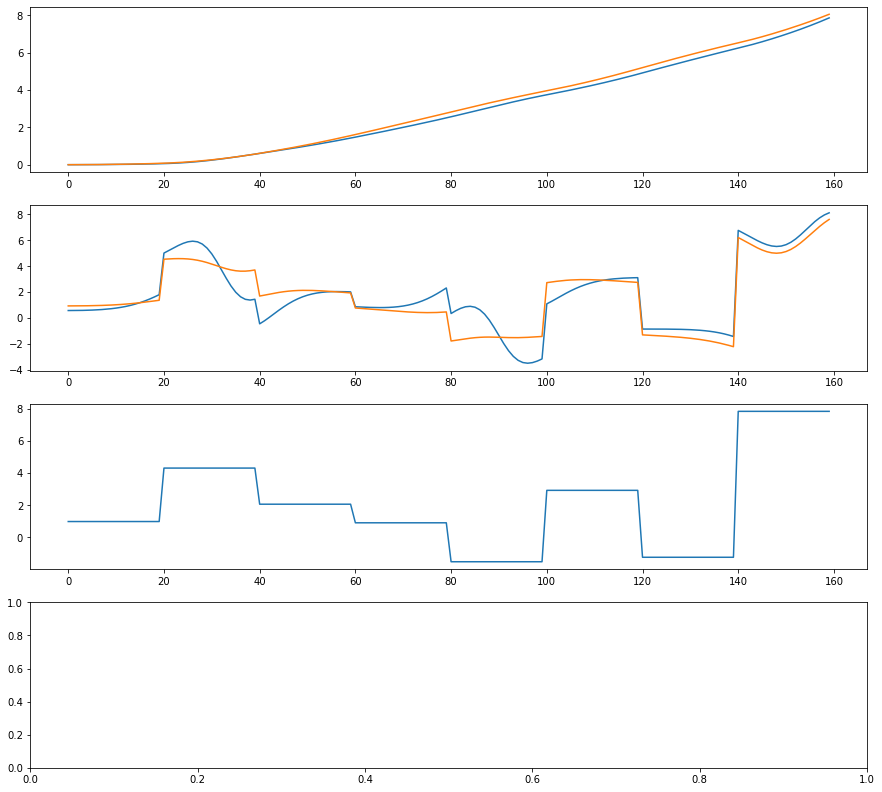

In [65]:
fig = plt.figure(figsize=(15,14))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

length = 200
dim = 0

ax1.plot(traj1_true[:length, 0])
ax1.plot(traj1[:length, 0])

ax2.plot(infos1[:length, 1])
ax2.plot(est_grad1[:length, 3])

ax3.plot(controls1[:length])

IndexError: list index out of range

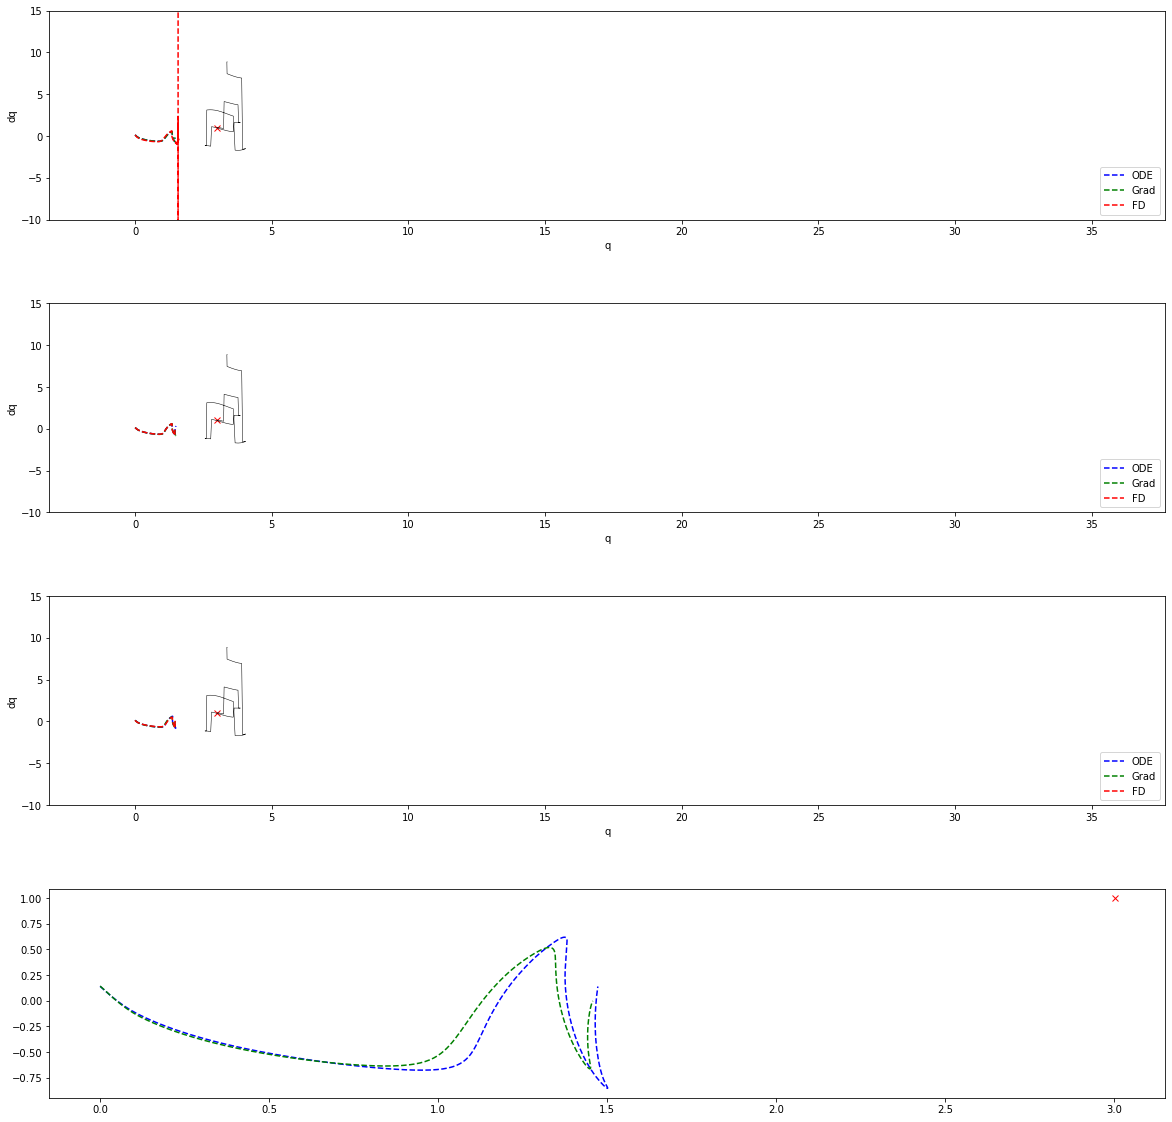

In [27]:
# Plot the trajectory generated from the model
# Phase Plot
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)

ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

axs = [ax1, ax2, ax3, ax4]

length = 165
for idx, ax in enumerate(axs):
#     ax.plot(infos1[0, 0], infos1[0, 1], marker='x', color="red")  # init pos
    ax.plot(infos2[0, 0], infos2[0, 1], marker='x', color="red")  # init pos

#     ax.plot(trajs1_recover[idx][:length, 0], trajs1_recover[idx][:length, 1], 'b--', label='ODE')
#     ax.plot(trajs1_recover[idx+4][:length, 0], trajs1_recover[idx+4][:length, 1], 'g--', label='Grad')
#     ax.plot(trajs1_recover[idx+8][:length, 0], trajs1_recover[idx+8][:length, 1], 'r--', label='FD')
#     ax.plot(infos1[:length, 0], infos1[:length, 1],
#             color='black', alpha=1, label='ground truth', linewidth=0.5)

    ax.plot(trajs2_recover[idx][:length, 0], trajs2_recover[idx][:length, 1], 'b--', label='ODE')
    ax.plot(trajs2_recover[idx+4][:length, 0], trajs2_recover[idx+4][:length, 1], 'g--', label='Grad')
    ax.plot(trajs2_recover[idx+8][:length, 0], trajs2_recover[idx+8][:length, 1], 'r--', label='FD')
    ax.plot(info_recover(infos2[:length, 0]), infos2[:length, 1],
            color='black', alpha=1, linewidth=0.5)

    ax.set_xlim([-np.pi, 12*np.pi])
    ax.set_ylim([-10, 15])
    ax.set_xlabel("q")
    ax.set_ylabel("dq")
    ax.legend(loc='lower right')
    
ax1.set_title("Hamiltonian Trajectories")
ax2.set_title("Lagrangian Trajectories")
ax3.set_title("Strcutred LODEN Trajectories")
ax4.set_title("Baseline Trajectories")

None

In [ ]:
# Plot the trajectory generated from the model
# Phase Plot
fig = plt.figure(figsize=(25, 6))
plt.subplots_adjust(hspace=0.4)

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

axs = [ax1, ax2, ax3, ax4]

length = 300
for idx, ax in enumerate(axs):
    ax.plot(infos1[0, 0], infos1[0, 1], marker='x', color="red")  # init pos
#     ax.plot(infos2[0, 0], infos2[0, 1], marker='x', color="red")  # init pos

    ax.plot(trajs1_recover[idx][:length, 0], trajs1_recover[idx][:length, 1], 'b--', label='ODE')
    ax.plot(trajs1_recover[idx+4][:length, 0], trajs1_recover[idx+4][:length, 1], 'g--', label='Grad')
    ax.plot(trajs1_recover[idx+8][:length, 0], trajs1_recover[idx+8][:length, 1], 'r--', label='FD')
    ax.plot(infos1[:length, 0], infos1[:length, 1],
            color='black', alpha=1, label='ground truth', linewidth=0.5)

#     ax.plot(trajs2_recover[idx][:length, 0], trajs2_recover[idx][:length, 1], 'b--', label='ODE')
#     ax.plot(trajs2_recover[idx+4][:length, 0], trajs2_recover[idx+4][:length, 1], 'g--', label='Grad')
#     ax.plot(trajs2_recover[idx+8][:length, 0], trajs2_recover[idx+8][:length, 1], 'r--', label='FD')
#     ax.plot(info_recover(infos2[:length, 0]), infos2[:length, 1],
#             color='black', alpha=1, linewidth=0.5)

    ax.set_xlim([-np.pi/2, np.pi/2])
    ax.set_ylim([-5, 5])
    ax.set_xlabel("q")
    ax.set_ylabel("dq")
    ax.legend(loc='lower right')
    
ax1.set_title("Hamiltonian Trajectories")
ax2.set_title("Lagrangian Trajectories")
ax3.set_title("Strcutred LODEN Trajectories")
ax4.set_title("Baseline Trajectories")

None

### Estimated Traj

In [ ]:
# Plot q(t) and p(t) graph
start = 0
end = 100
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)

ax1.plot(t_span[start:end], trajs2_recover[0][start:end, 0], 'b--', label='HNN')
ax1.plot(t_span[start:end], trajs2_recover[1][start:end, 0], 'g--', label='LNN')
ax1.plot(t_span[start:end], trajs2_recover[2][start:end, 0], 'r--', label='Structured')
ax1.plot(t_span[start:end], trajs2_recover[3][start:end, 0], 'y--', label='Baseline')

ax1.plot(t_span[start:end], info_recover(infos2[start:end, 0]), color='black', alpha=0.5)  # traj

ax1.set_xlabel("t")
ax1.set_ylabel("q")
ax1.set_title("q(t)")

ax2 = fig.add_subplot(212)
ax2.plot(t_span[start:end], trajs2_recover[0][start:end, 1], 'b--', label='HNN')
ax2.plot(t_span[start:end], trajs2_recover[1][start:end, 1], 'g--', label='LNN')
ax2.plot(t_span[start:end], trajs2_recover[2][start:end, 1], 'r--', label='Structured')
ax2.plot(t_span[start:end], trajs2_recover[3][start:end, 1], 'y--', label='Baseline')

ax2.plot(t_span[start:end], infos2[start:end, 1], color='black', alpha=0.5)  # traj

ax2.set_xlabel("t")
ax2.set_ylabel("dq")
ax2.set_title("dq(t)")

ax1.legend()
ax2.legend()
fig.tight_layout(pad=2.0)
None

### Estimated Force

In [ ]:
ddq1 = []
ddq2 = []
for idx, model in enumerate(models):
    q_dq_u1 = torch.cat([torch.tensor(traj1_true), controls1], dim=1)
    est_grad1 = model.defunc(0, q_dq_u1.float()).detach()
    ddq1.append(est_grad1)
    q_dq_u2 = torch.cat([torch.tensor(traj2_true), controls2], dim=1)
    est_grad2 = model.defunc(0, q_dq_u2.float()).detach()
    ddq2.append(est_grad2)

In [ ]:
# Plot q(t) and p(t) graph
start = 0
end = 100
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(211)

ax1.plot(t_span[start:end], ddq1[0][start:end, 2], 'b--', label='HNN', linewidth=1)
ax1.plot(t_span[start:end], ddq1[1][start:end, 2], 'g--', label='LNN', linewidth=1)
ax1.plot(t_span[start:end], ddq1[2][start:end, 2], 'r--', label='Structured', linewidth=1)
ax1.plot(t_span[start:end], ddq1[3][start:end, 2], 'y--', label='Baseline', linewidth=1)

ax1.plot(t_span[start:end], infos1[start:end, 2], color='black', alpha=0.5, label="Ground Truth")  # traj

ax1.set_xlabel("t")
ax1.set_ylabel("ddq")
ax1.set_title("ddq(t)")

ax2 = fig.add_subplot(212)
ax2.plot(t_span[start:end], controls1[start:end, 0], color='black', alpha=0.5)  # traj

ax2.set_xlabel("t")
ax2.set_ylabel("u")
ax2.set_title("Control")

ax1.legend()
ax1.set_ylim([-22, 22])
fig.tight_layout(pad=1.0)
None

In [ ]:
# Plot q(t) and p(t) graph
start = 0
end = 100
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(211)

ax1.plot(t_span[start:end], ddq2[0][start:end, 2], 'b--', label='HNN', linewidth=1)
ax1.plot(t_span[start:end], ddq2[1][start:end, 2], 'g--', label='LNN', linewidth=1)
ax1.plot(t_span[start:end], ddq2[2][start:end, 2], 'r--', label='Structured', linewidth=1)
ax1.plot(t_span[start:end], ddq2[3][start:end, 2], 'y--', label='Baseline', linewidth=1)

ax1.plot(t_span[start:end], infos2[start:end, 2], color='black', alpha=0.5, label="Ground Truth")  # traj

ax1.set_xlabel("t")
ax1.set_ylabel("ddq")
ax1.set_title("ddq(t)")

ax2 = fig.add_subplot(212)
ax2.plot(t_span[start:end], controls2[start:end, 0], color='black', alpha=0.5)  # traj

ax2.set_xlabel("t")
ax2.set_ylabel("u")
ax2.set_title("Control")

ax1.legend()
# ax1.set_ylim([-22, 22])
fig.tight_layout(pad=1.0)
None

In [ ]:
test_model = models[0]

In [ ]:
with torch.no_grad():
    n_grid = 100
    x = torch.linspace(-2 * np.pi, 2 * np.pi, n_grid)
    y = torch.linspace(-10, 10, n_grid)
    Q, dQ = torch.meshgrid(x, y)  # all (q, p)

    L, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

    for i in range(n_grid):
        for j in range(n_grid):
            x = torch.cat([torch.cos(Q[i, j].reshape(1, 1)),
                           torch.sin(Q[i, j].reshape(1, 1)),
                           dQ[i, j].reshape(1, 1)], 1)
            x_u = torch.cat([x, torch.zeros(1, 1)], dim=1)
            
            L[i, j] = test_model.defunc.m.H(x)
            grad = test_model.defunc(0, x_u).detach().cpu()
            # U[i, j], V[i, j] = -grad[:, 0]/torch.sin(Q[i, j].reshape(1, 1)), grad[:, 2]
            U[i, j], V[i, j] = grad[:, 1]/torch.cos(Q[i, j].reshape(1, 1)), grad[:, 2]

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
CS = ax.contourf(Q, dQ, L, 100, cmap='RdYlBu')
fig.colorbar(CS)

# ax.streamplot(Q.T.numpy(), dQ.T.numpy(), U.T.numpy(), V.T.numpy(), color='black')
ax.streamplot(Q.T.numpy(), dQ.T.numpy(), U.T.numpy(), V.T.numpy(), color='black')

ax.set_xlim([Q.min(), Q.max()])
ax.set_ylim([dQ.min(), dQ.max()])
ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Lagrangian")
None

In [ ]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
x1, x2 = torch.meshgrid(x, x)  # (cos q, sin q)

Control = 1. * 10 * torch.ones_like(x)

C_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    C_est[i] = test_model.defunc.m.controlNet(q.view(1, -1)).detach().cpu()

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), C_est, '--', label='Control_est')
# ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("g(q)")
ax.set_title("Control")
None